# LSTM Stock Predictor Using Closing Prices

## Data Preparation

In [31]:
import numpy as np
import pandas as pd
import hvplot.pandas
from numpy.random import seed
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler

In [56]:
# Set the random seed for reproducibility
seed(1)
random.set_seed(2)

In [33]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('/Users/erahm/Downloads/btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [34]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [35]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [36]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [37]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X and y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [38]:
# Set the features (X) and target (y) data using the window_data() function
window_size = 10
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [57]:
# Set aside 70% of the data for training and leave the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [58]:
# Scale data between 0 and 1 with MinMaxScaler

# Create a MinMaxScaler variable
scaler = MinMaxScaler()

# Fit the MinMaxScaler variable with the features data X
scaler.fit(X_train)

# Scale the features within the training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler variable with the target data Y
scaler.fit(y_train)

# Finally, the target training and testing sets can be scaled
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [41]:
# Reshape the model features for X_train and X_test
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# After reshaping the X_train and X_test datasets, print out some sample values
print (f"Sample values for X_train:\n{X_train} \n")
print (f"Sample values for X_test:\n{X_test}")

Sample values for X_train:
[[[0.7111066 ]
  [0.68162134]
  [0.72761425]
  ...
  [0.60786209]
  [0.66058747]
  [0.64516902]]

 [[0.68162134]
  [0.72761425]
  [0.60270722]
  ...
  [0.66058747]
  [0.64516902]
  [0.58657552]]

 [[0.72761425]
  [0.60270722]
  [0.44784942]
  ...
  [0.64516902]
  [0.58657552]
  [0.68651129]]

 ...

 [[0.01726567]
  [0.05168335]
  [0.05074402]
  ...
  [0.0430626 ]
  [0.04363925]
  [0.04651042]]

 [[0.05168335]
  [0.05074402]
  [0.05471891]
  ...
  [0.04363925]
  [0.04651042]
  [0.05299984]]

 [[0.05074402]
  [0.05471891]
  [0.04579717]
  ...
  [0.04651042]
  [0.05299984]
  [0.05299984]]] 

Sample values for X_test:
[[[0.05471891]
  [0.04579717]
  [0.04653096]
  ...
  [0.05299984]
  [0.05299984]
  [0.08221318]]

 [[0.04579717]
  [0.04653096]
  [0.0451359 ]
  ...
  [0.05299984]
  [0.08221318]
  [0.08362397]]

 [[0.04653096]
  [0.0451359 ]
  [0.0430626 ]
  ...
  [0.08221318]
  [0.08362397]
  [0.08964557]]

 ...

 [[0.74842817]
  [0.78139637]
  [0.89529984]
  ...


---

## Build and Train the LSTM RNN

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout

In [59]:
# Define the LSTM RNN model
model = Sequential()

number_units = 10  # The number of units indicates the size of the time window in each LSTM layer. In this case, our number_units = 10 since we are using a 10-day time window to predict the 11th day closing price.
dropout_fraction = 0.2 # The dropout fraction is set to 0.2, which means that 20% of the neurons will be randomly removed on each epoch.

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True, # With return_sequence set to "True" we will get the results for all hidden states of all the time steps.
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction)) # In order to prevent overfitting of our model, 20% of the units will be dropped on each epoch.
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [60]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [61]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 10)            480       
                                                                 
 dropout_3 (Dropout)         (None, 10, 10)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 10)            840       
                                                                 
 dropout_4 (Dropout)         (None, 10, 10)            0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [62]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=32, verbose=1)
# Here we are setting shuffle = False since we want our data to remain sequential as we are working with time-series data
# By testing/updating the batch_size to "32", we find that the smaller batch size performs significantly better than a batch size of 90 or 64

Epoch 1/10
12/12 [==============================] - 7s 14ms/step - loss: 0.1958
Epoch 2/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1179
Epoch 3/10
12/12 [==============================] - 0s 25ms/step - loss: 0.0682
Epoch 4/10
12/12 [==============================] - 0s 17ms/step - loss: 0.0431
Epoch 5/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0390
Epoch 6/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0365
Epoch 7/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0302
Epoch 8/10
12/12 [==============================] - 0s 13ms/step - loss: 0.0287
Epoch 9/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0235
Epoch 10/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0218


---

## Model Performance

In [63]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.021092204377055168

In [64]:
# Make some predictions
predicted = model.predict(X_test)

In [65]:
# Retrieve the original prices in lieu of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [52]:
# Create a DataFrame of the Real and Predicted values
btc_prices = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
btc_prices.head()

,Real,Predicted
2019-02-20,3924.239990,4606.336914
2019-02-21,3974.050049,4607.106445
2019-02-22,3937.040039,4618.724121
2019-02-23,3983.530029,4634.201660
2019-02-24,4149.089844,4654.963379


<AxesSubplot:title={'center':'Actual Vs. Predicted Bitcoin Values'}>

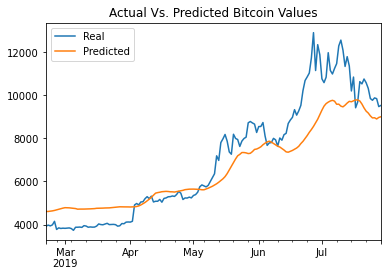

In [54]:
# Plot a line chart of the real vs predicted Bitcoin values 
btc_prices.plot(title="Actual Vs. Predicted Bitcoin Values")